In [1]:
import re
import string

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from collections import Counter

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, Normalizer

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

from sentence_transformers import SentenceTransformer

/Users/doski/miniconda3/envs/getinno-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_json('../Datasets/sarcasm_data.json')

In [3]:
data.head()

,160,170,180,190,1105,1162,1175,1182,1213,1276,...,2623,2131,2236,2546,2242,2169,2235,234,2608,2524
utterance,It's just a privilege to watch your mind at work.,I don't think I'll be able to stop thinking ab...,"Since it's not bee season, you can have my epi...","Lois Lane is falling, accelerating at an initi...",I'm just inferring this is a couch because the...,"Sheldon, if you were a robot, and I knew and y...",If you're compiling a mix CD for a double suic...,No. The dark crescent-shaped patterns under yo...,"How's this? ""Pleased to meet you, Dr. Gablehau...","Yeah, my parents felt that naming me Leonard a...",...,What do you know? Its a treat for the eyes and...,I really don't wanna sit with Allen Iverson ov...,"Gee, if only she were one and had no idea what...","Oh sure, she was probably up all night excited...",Are you still enjoying your nap?,"Hes not right for the part, and if I suggest h...","Oh yeah he has a caretaker his older brother, ...",Is it me or the greetings gone downhill around...,"You are right, by saying nice, I am virtually ...","Yes and we are ""very"" excited about it."
speaker,SHELDON,PENNY,SHELDON,SHELDON,SHELDON,HOWARD,SHELDON,SHELDON,SHELDON,LEONARD,...,CHANDLER,CHANDLER,CHANDLER,CHANDLER,CHANDLER,CHANDLER,CHANDLER,CHANDLER,CHANDLER,CHANDLER
context,[I never would have identified the fingerprint...,[This is one of my favorite places to kick bac...,"[Here we go. Pad thai, no peanuts., But does i...",[A marathon? How many Superman movies are ther...,"[Great Caesar's ghost, look at this place., So...","[On the other hand, no arousal., None?, None.,...","[Oh, good Lord., God, that's a good song.]","[How do I look?, Could you be more specific?, ...","[You know, I am not going to enjoy this party....",[He switched over to high-energy radiation res...,...,"[Chandler?, Hey! Ah!, What do you think?, I th...",[Wish I could switch with someone.],"[You can't go away this weekend, its Emma's bi...","[Hey, Hey, where's the birthday girl?, Oh she ...","[Okay?, Hi Emma, it's the year 2020.]","[What am I gonna do now?, Just pass the tape a...","[Helo! Anybody in there order a celebrity?, Wh...","[Hey, You son of a bitch!]","[Did I go to this school?, Hey, there's Missy ...","[Anyway, if you don't feel like being alone to..."
context_speakers,"[LEONARD, SHELDON]","[HOWARD, PENNY, HOWARD, HOWARD, HOWARD, PENNY,...","[LEONARD, HOWARD, LEONARD]","[PENNY, SHELDON, PENNY, SHELDON, SHELDON, PENN...","[SHELDON, LEONARD, SHELDON, SHELDON, SHELDON, ...","[PERSON, LEONARD, PERSON, LEONARD, PERSON, LEO...","[SHELDON, LEONARD]","[LEONARD, SHELDON, LEONARD]","[SHELDON, LEONARD, SHELDON, LEONARD, SHELDON, ...","[PERSON, PERSON, LEONARD, PERSON, LEONARD, PER...",...,"[PHOEBE, CHANDLER, MONICA, CHANDLER]",[CHANDLER],"[RACHEL, MONICA, RACHEL]","[MONICA, CHANDLER, RACHEL]","[ROSS, CHANDLER]","[CHANDLER, RACHEL]","[JOEY, PERSON, CHANDLER, PERSON]","[CHANDLER, JOEY]","[CHANDLER, ROSS, CHANDLER, ROSS]",[ROSS]
show,BBT,BBT,BBT,BBT,BBT,BBT,BBT,BBT,BBT,BBT,...,FRIENDS,FRIENDS,FRIENDS,FRIENDS,FRIENDS,FRIENDS,FRIENDS,FRIENDS,FRIENDS,FRIENDS


In [4]:
data = data.T

In [5]:
data.head()

,utterance,speaker,context,context_speakers,show,sarcasm
160,It's just a privilege to watch your mind at work.,SHELDON,[I never would have identified the fingerprint...,"[LEONARD, SHELDON]",BBT,True
170,I don't think I'll be able to stop thinking ab...,PENNY,[This is one of my favorite places to kick bac...,"[HOWARD, PENNY, HOWARD, HOWARD, HOWARD, PENNY,...",BBT,True
180,"Since it's not bee season, you can have my epi...",SHELDON,"[Here we go. Pad thai, no peanuts., But does i...","[LEONARD, HOWARD, LEONARD]",BBT,False
190,"Lois Lane is falling, accelerating at an initi...",SHELDON,[A marathon? How many Superman movies are ther...,"[PENNY, SHELDON, PENNY, SHELDON, SHELDON, PENN...",BBT,False
1105,I'm just inferring this is a couch because the...,SHELDON,"[Great Caesar's ghost, look at this place., So...","[SHELDON, LEONARD, SHELDON, SHELDON, SHELDON, ...",BBT,True


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 160 to 2524
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   utterance         690 non-null    object
 1   speaker           690 non-null    object
 2   context           690 non-null    object
 3   context_speakers  690 non-null    object
 4   show              690 non-null    object
 5   sarcasm           690 non-null    object
dtypes: object(6)
memory usage: 53.9+ KB


In [7]:
data.show.value_counts(dropna=False)

FRIENDS           356
BBT               280
GOLDENGIRLS        40
SARCASMOHOLICS     14
Name: show, dtype: int64

In [8]:
data.sarcasm.value_counts(dropna=False)

True     345
False    345
Name: sarcasm, dtype: int64

In [9]:
data.rename(columns={'utterance': 'comment', 'sarcasm': 'label'}, inplace=True)

In [10]:
df = data[['comment', 'label']].reset_index()

In [11]:
df['comment'] = df['comment'].str.lower()

In [12]:
df.head()

,index,comment,label
0,160,it's just a privilege to watch your mind at work.,True
1,170,i don't think i'll be able to stop thinking ab...,True
2,180,"since it's not bee season, you can have my epi...",False
3,190,"lois lane is falling, accelerating at an initi...",False
4,1105,i'm just inferring this is a couch because the...,True


In [13]:
df.replace({'label': {True: 1, False: 0}}, inplace=True)

In [14]:
df.head()

,index,comment,label
0,160,it's just a privilege to watch your mind at work.,1
1,170,i don't think i'll be able to stop thinking ab...,1
2,180,"since it's not bee season, you can have my epi...",0
3,190,"lois lane is falling, accelerating at an initi...",0
4,1105,i'm just inferring this is a couch because the...,1


In [15]:
df['comment_words'] = df['comment'].apply(lambda x: x.split(' '))

In [16]:
df['message_len'] = df['comment_words'].apply(len)

In [17]:
df.head()

,index,comment,label,comment_words,message_len
0,160,it's just a privilege to watch your mind at work.,1,"[it's, just, a, privilege, to, watch, your, mi...",10
1,170,i don't think i'll be able to stop thinking ab...,1,"[i, don't, think, i'll, be, able, to, stop, th...",11
2,180,"since it's not bee season, you can have my epi...",0,"[since, it's, not, bee, season,, you, can, hav...",10
3,190,"lois lane is falling, accelerating at an initi...",0,"[lois, lane, is, falling,, accelerating, at, a...",51
4,1105,i'm just inferring this is a couch because the...,1,"[i'm, just, inferring, this, is, a, couch, bec...",20


In [18]:
Counter(df.comment_words.sum()).most_common(100)

[('i', 267),
 ('a', 257),
 ('the', 244),
 ('you', 228),
 ('to', 212),
 ('and', 146),
 ('of', 123),
 ('in', 99),
 ('that', 90),
 ('it', 77),
 ('my', 75),
 ('is', 75),
 ('just', 71),
 ("i'm", 65),
 ('was', 63),
 ('have', 60),
 ("don't", 55),
 ('for', 55),
 ('with', 55),
 ('on', 54),
 ('all', 51),
 ('your', 50),
 ('not', 49),
 ('if', 49),
 ('we', 49),
 ('what', 48),
 ("it's", 46),
 ('me', 45),
 ('but', 44),
 ('like', 43),
 ('no,', 42),
 ('no', 41),
 ('so', 41),
 ('do', 41),
 ('this', 40),
 ('about', 39),
 ('oh,', 37),
 ('are', 37),
 ('he', 35),
 ('be', 34),
 ('am', 33),
 ('an', 32),
 ('out', 32),
 ("you're", 32),
 ('oh', 32),
 ('can', 31),
 ('she', 31),
 ('at', 29),
 ('think', 28),
 ('go', 27),
 ('yeah,', 26),
 ('well,', 26),
 ('when', 26),
 ('her', 25),
 ('because', 25),
 ('up', 24),
 ('how', 24),
 ('see', 24),
 ('it.', 23),
 ('got', 23),
 ('know', 23),
 ("that's", 23),
 ('would', 22),
 ('going', 22),
 ('really', 22),
 ('you.', 21),
 ('good', 21),
 ('get', 21),
 ('gonna', 21),
 ('as', 20

In [19]:
df['comment_words'] = df['comment_words'].apply(
    lambda x: [''.join(re.findall('[\s\w\d]', word)) for word in x if (
        (word not in string.punctuation) and (word not in STOP_WORDS)
    )]
)

In [20]:
df.head()

,index,comment,label,comment_words,message_len
0,160,it's just a privilege to watch your mind at work.,1,"[its, privilege, watch, mind, work]",10
1,170,i don't think i'll be able to stop thinking ab...,1,"[dont, think, ill, able, stop, thinking, it]",11
2,180,"since it's not bee season, you can have my epi...",0,"[its, bee, season, epinephrine]",10
3,190,"lois lane is falling, accelerating at an initi...",0,"[lois, lane, falling, accelerating, initial, r...",51
4,1105,i'm just inferring this is a couch because the...,1,"[im, inferring, couch, evidence, suggests, cof...",20


In [21]:
en_model = spacy.load('en_core_web_sm')

In [22]:
df['lemma'] = df['comment_words'].apply(lambda x: ' '.join([token.lemma_ for token in en_model(' '.join(x))]))

In [23]:
# df['embeddings'] = df['comment'].apply(lambda x: [np.mean(token.vector) for token in en_model(x)])

In [24]:
df.head()

,index,comment,label,comment_words,message_len,lemma
0,160,it's just a privilege to watch your mind at work.,1,"[its, privilege, watch, mind, work]",10,its privilege watch mind work
1,170,i don't think i'll be able to stop thinking ab...,1,"[dont, think, ill, able, stop, thinking, it]",11,do not think ill able stop think it
2,180,"since it's not bee season, you can have my epi...",0,"[its, bee, season, epinephrine]",10,its bee season epinephrine
3,190,"lois lane is falling, accelerating at an initi...",0,"[lois, lane, falling, accelerating, initial, r...",51,lois lane fall accelerate initial rate 32 foot...
4,1105,i'm just inferring this is a couch because the...,1,"[im, inferring, couch, evidence, suggests, cof...",20,I m infer couch evidence suggest coffee table ...


In [25]:
reddit_data = pd.read_csv('../Datasets/clean_reddit_data.csv')

In [26]:
# df = pd.concat([df, reddit_data], ignore_index=True)

In [27]:
# df.fillna(' ', inplace=True)

In [28]:
# df.head()

In [29]:
# df.info()

In [30]:
train_reddit, test_reddit = train_test_split(
    reddit_data, 
    train_size=10000-int(345*0.6),
    test_size=2000-int(345*0.4),
    random_state=9
)

In [31]:
train_movies, test_movies = train_test_split(
    df,
    train_size=0.6,
    random_state=9
)

In [32]:
train = pd.concat([train_reddit, train_movies], ignore_index=True)
test = pd.concat([test_reddit, test_movies], ignore_index=True)

**Sarcasm prediction using other models from hugging face "helinivan/english-sarcasm-detector"**

In [33]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import string

In [34]:
def preprocess_data(text: str) -> str:
    return text.lower().translate(str.maketrans("", "", string.punctuation)).strip()

In [35]:
MODEL_PATH = "helinivan/english-sarcasm-detector"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

In [36]:
# Split data into train-test chunks
Xtrain = train[['comment']]
Xtest = test[['comment']]
ytrain = train[['label']]
ytest = test[['label']]

In [37]:
Xtest['tokenized_text'] = Xtest['comment'].apply(lambda x: tokenizer(
    [preprocess_data(x)], padding=True, truncation=True, max_length=256, return_tensors="pt"))

<ipython-input-37-2fde5226a29c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest['tokenized_text'] = Xtest['comment'].apply(lambda x: tokenizer(


In [38]:
Xtest['y'] = Xtest['tokenized_text'].apply(lambda x: model(**x).logits.softmax(dim=-1).tolist()[0])

<ipython-input-38-f00dbae12cee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest['y'] = Xtest['tokenized_text'].apply(lambda x: model(**x).logits.softmax(dim=-1).tolist()[0])


In [39]:
Xtest['y_hat'] = Xtest['y'].apply(lambda x: x.index(max(x)))

<ipython-input-39-47ee19ead072>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest['y_hat'] = Xtest['y'].apply(lambda x: x.index(max(x)))


In [40]:
# View the classification report
print(classification_report(ytest, Xtest['y_hat']))

              precision    recall  f1-score   support

           0       0.48      0.81      0.61      1044
           1       0.50      0.18      0.27      1094

    accuracy                           0.49      2138
   macro avg       0.49      0.49      0.44      2138
weighted avg       0.49      0.49      0.43      2138



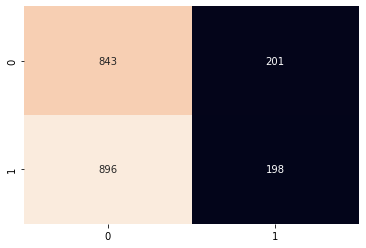

In [41]:
# Plot the confusion matrix
ax = sns.heatmap(
    confusion_matrix(ytest, Xtest['y_hat']), 
    annot=True, 
    cbar=False, 
    fmt='d'
)

**Sarcasm prediction using other models from hugging face "Hexye/sarcasm-classifier"**

In [42]:
MODEL_PATH = "Hexye/sarcasm-classifier"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

In [43]:
# Split data into train-test chunks
Xtrain = train[['comment']]
Xtest = test[['comment']]
ytrain = train[['label']]
ytest = test[['label']]

In [44]:
Xtest['tokenized_text'] = Xtest['comment'].apply(lambda x: tokenizer(
    [preprocess_data(x)], padding=True, truncation=True, max_length=256, return_tensors="pt"))

<ipython-input-44-2fde5226a29c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest['tokenized_text'] = Xtest['comment'].apply(lambda x: tokenizer(


In [ ]:
Xtest['y'] = Xtest['tokenized_text'].apply(lambda x: model(**x).logits.softmax(dim=-1).tolist()[0])

In [ ]:
Xtest['y_hat'] = Xtest['y'].apply(lambda x: x.index(max(x)))

In [ ]:
# View the classification report
print(classification_report(ytest, Xtest['y_hat']))

In [ ]:
# Plot the confusion matrix
ax = sns.heatmap(
    confusion_matrix(ytest, Xtest['y_hat']), 
    annot=True, 
    cbar=False, 
    fmt='d'
)

**Sarcasm prediction using other models from hugging face "brahimje/roberta-sarcasm-detection"**

In [ ]:
MODEL_PATH = "brahimje/roberta-sarcasm-detection"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

In [ ]:
# Split data into train-test chunks
Xtrain = train[['comment']]
Xtest = test[['comment']]
ytrain = train[['label']]
ytest = test[['label']]

In [ ]:
Xtest['tokenized_text'] = Xtest['comment'].apply(lambda x: tokenizer(
    [preprocess_data(x)], padding=True, truncation=True, max_length=256, return_tensors="pt"))

In [ ]:
Xtest['y'] = Xtest['tokenized_text'].apply(lambda x: model(**x).logits.softmax(dim=-1).tolist()[0])

In [ ]:
Xtest['y_hat'] = Xtest['y'].apply(lambda x: x.index(max(x)))

In [ ]:
# View the classification report
print(classification_report(ytest, Xtest['y_hat']))

In [ ]:
# Plot the confusion matrix
ax = sns.heatmap(
    confusion_matrix(ytest, Xtest['y_hat']), 
    annot=True, 
    cbar=False, 
    fmt='d'
)